In [1]:
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

import warnings

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

* 42d & 21d T10Y3M: if slope absolute value is decreasing: flattener; otherwise steepener.
* 180d interest rate: if positive bear; otherwise bull.

In [2]:
T10Y3M = pd.read_csv('../data/T10Y3M.csv', na_values='.')
DGS5 = pd.read_csv('../data/DGS5.csv', na_values='.')

T10Y3M['DATE'] = pd.to_datetime(T10Y3M['DATE'])
DGS5['DATE'] = pd.to_datetime(DGS5['DATE'])

T10Y3M = T10Y3M[('2010' < T10Y3M['DATE'])]
DGS5 = DGS5[('2010' < DGS5['DATE'])]

T10Y3M['date_ordinal'] = T10Y3M['DATE'].apply(lambda date: date.toordinal())
DGS5['date_ordinal'] = DGS5['DATE'].apply(lambda date: date.toordinal())

T10Y3M = T10Y3M.set_index('DATE')
DGS5 = DGS5.set_index('DATE')

T10Y3M = T10Y3M.reindex(pd.date_range(min(T10Y3M.index), max(T10Y3M.index)))
DGS5 = DGS5.reindex(pd.date_range(min(DGS5.index), max(DGS5.index)))

In [3]:
X = sm.add_constant(T10Y3M['date_ordinal'])
Y = T10Y3M['T10Y3M']
slope_42 = RollingOLS(Y, X, window=42).fit().params['date_ordinal']
slope_21 = RollingOLS(Y, X, window=21).fit().params['date_ordinal']

T10Y3M['flatten'] = np.abs(slope_42) > np.abs(slope_21)
T10Y3M['flatten'][:41] = np.nan

X = sm.add_constant(DGS5['date_ordinal'])
Y = DGS5['DGS5']
slope_180 = RollingOLS(Y, X, window=180).fit().params['date_ordinal']

DGS5['bear'] = slope_180 > 0
DGS5['bear'][:179] = np.nan

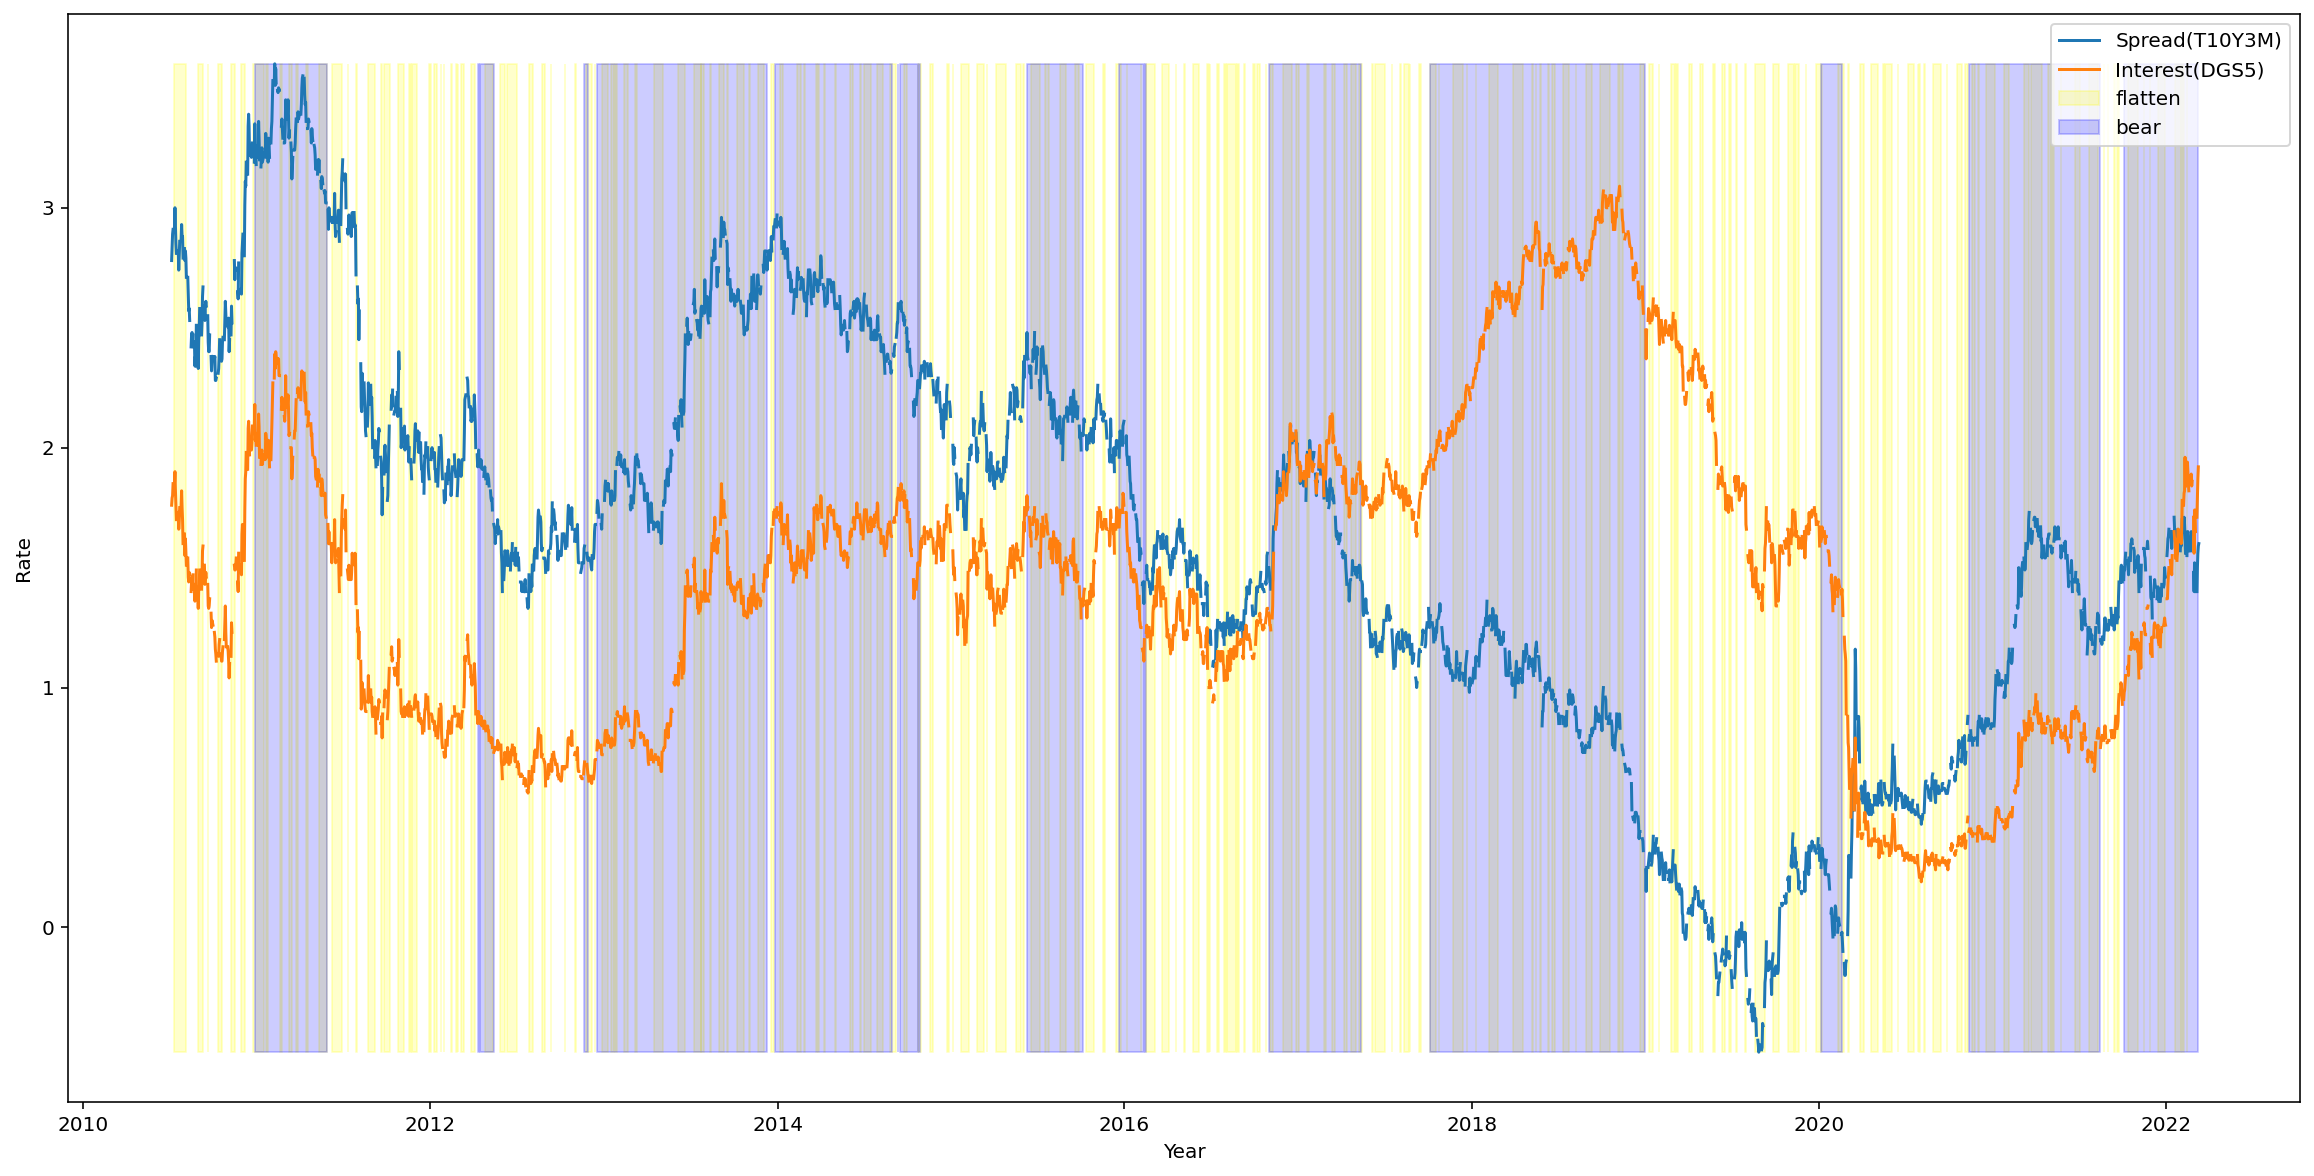

In [4]:
T10Y3M = T10Y3M.iloc[179:]
DGS5 = DGS5.iloc[179:]

plt.figure(figsize=(20, 10))
plt.xlabel('Year')
plt.ylabel('Rate')
plt.plot(T10Y3M.index, T10Y3M['T10Y3M'], label='Spread(T10Y3M)')
plt.plot(DGS5.index, DGS5['DGS5'], label='Interest(DGS5)')
max_y = max(DGS5['DGS5'].max(), T10Y3M['T10Y3M'].max())
min_y = min(DGS5['DGS5'].min(), T10Y3M['T10Y3M'].min())
plt.fill_between(T10Y3M.index,
                 max_y,
                 min_y,
                 where=T10Y3M['flatten'],
                 color='yellow',
                 alpha=0.2,
                 label='flatten')
plt.fill_between(DGS5.index,
                 max_y,
                 min_y,
                 where=DGS5['bear'],
                 color='blue',
                 alpha=0.2,
                 label='bear')
plt.legend()